In [2]:
import os, sys, math, importlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
import tensorflow_io as tfio
import tensorflow_datasets as tfds

#import skimage.transform as trans
#import cv_image_proc

#tf.config.run_functions_eagerly(True) # this is needed for debugging!!!
#tf.data.experimental.enable_debug_mode() # eager execution of tf.data functions

print(f"Function exec eagerly: {tf.executing_eagerly()}")
print(tf.config.list_physical_devices('GPU'))
print(f"Tensorflow version: {tf.__version__} tf io: {tfio.__version__}")


Function exec eagerly: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.10.1 tf io: 0.26.0


In [65]:
import CAE_model, common
importlib.reload(CAE_model)
importlib.reload(common)
from CAE_model import CAE_generic
from common import *
from enum import IntEnum

# any tf functions are accessed through backend
# K.softmax, K.stack, K.argmin
# this prepares the main data set by parsing files, could take long

NAS_dir = "Y:/Schwind/Titan/FeldTest_SW1.2/original/"
base_dir = "C:/SchwindResource/FieldTest/"
#csv_set = tf.data.Dataset.list_files(base_dir + "Vid3_*.csv")
csv_set = tf.data.Dataset.list_files(base_dir + "*.csv")
origSize = (800,800)
scaledSize = (512,512)
cropFactor = float(scaledSize[0]) / origSize[0] # central crop factor to reduce image size.. 
ofsX, ofsY = float(origSize[0] - scaledSize[0])/2, float(origSize[1] - scaledSize[1])/2
imageShape = (256,256,1)

#vidFile = NAS_dir + "20210519/Patient1/2021-05-14__08-46-05__13388512_SUNJO_Graciela_OD.Cam1VID._TiCam1_210514_084605.avi"
#zz = tfio.IODataset.from_ffmpeg(", #               "v:0")
#vid = tfio.experimental.ffmpeg.decode_video(vidFile, "0")

class CSV(IntEnum):
    FName = 0,
    FrameNo = 1,
    EyeCode = 2,
    PupilQ = 3,
    PupilX = 4,
    PupilY = 5,
    PupilR = 6

def loadByFrameNo(*csv):
    frameS = tf.strings.as_string(csv[CSV.FrameNo], width=6, fill='0')
    name = csv[CSV.FName] + frameS + '.png'
    bytes = tf.io.read_file(name)
    image = tf.io.decode_png(bytes)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image =  tf.image.central_crop(image, cropFactor)
    Q, X, Y, R = csv[CSV.PupilQ:]
    img = tf.image.resize(image, imageShape[:-1])
    img -= tf.math.reduce_mean(img, keepdims=True)
    img /= (tf.math.reduce_std(img, keepdims=True) + 1e-6)
    #img = img - tf.reduce_mean(img)
    #name += "_Q" + tf.strings.as_string(Q)
    return (img, \
        tf.convert_to_tensor([(X - ofsX)/2, (Y - ofsY)/2, R/2], dtype=tf.float32)) #, name) 

class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x))
    self.std = tf.Variable(tf.math.reduce_std(x))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean
   
# FrameNo ; EyeCode ; PupilQ ; PupilX  ; PupilY  ; PupilR ; CycloQ ; Angle  ; PSTValue ; RadStdDev ; AvgGradient ; MaxHoughCenter ; 
csvFields = [str(), int(), str(), int(), float(), float(), float()] #, float(), float(), float(), float(), float(), float()]
def singleCSV(fname):
    # NOTE: perhaps makes sense not to take all frames but with some step??
    # choose only those frames which are OK (eyecode is OK)
    framesDir = tf.strings.regex_replace(fname, '_sim[0-9]+\.csv', '_Frames\\\\scene;')

    return tf.data.TextLineDataset(fname).filter(lambda x: tf.strings.regex_full_match(x, "\d+\s+;\s*OK\s.*")). \
        map(lambda x: tf.io.decode_csv(tf.strings.join([framesDir,x]), csvFields, field_delim=';', select_cols=[0,1,2,3,4,5,6])). \
        filter(lambda *csv: csv[CSV.FrameNo] > 20 and csv[CSV.FrameNo] % 13 == 0) 
        # skip first 20 frames used for white ring detection, and choose every 7th frame

# def cv_process_images(Test = False):
#     for file in file_set:
#         #  NOTE: we should either reset dynamic params or process image in order !!!
#         image, qua, X, Y, R = cv_image_proc.detect_pupil(file.numpy(), isReference=False)
#         image = tf.expand_dims(image, axis=-1)
#         # NOTE: here we could skip some files where no pupil has been found..
#         sc = np.float32(imageShape[0]) / image.shape[0]
#         #print(f"LOAD: pupil: {qua} ({X},{Y}) @ {R} -- {scale}")
#         yield tf.image.resize(image, imageShape[:-1]), tf.constant([qua, X*sc, Y*sc, R*sc])


C:\SchwindResource\FieldTest\Vid86_2021-09-03__13-41-09__Patient8_Frames\scene003796.png_Q77
C:\SchwindResource\FieldTest\Vid83_2021-09-03__11-46-22__Patient5_Frames\scene006578.png_Q53
C:\SchwindResource\FieldTest\Vid85_2021-09-03__13-26-43__Patient7_Frames\scene002119.png_Q96
C:\SchwindResource\FieldTest\Vid60_2021-08-16__12-20-14__Patient2_Frames\scene003107.png_Q52
C:\SchwindResource\FieldTest\Vid82_2021-09-03__11-34-07__Patient4_Frames\scene001079.png_Q70
C:\SchwindResource\FieldTest\Vid67_2021-08-20__09-36-31__Patient2_Frames\scene001118.png_Q87
C:\SchwindResource\FieldTest\Vid63_2021-08-16__14-04-48__Patient5_Frames\scene001742.png_Q72
C:\SchwindResource\FieldTest\Vid23_2021-07-22__11-57-44__Patient3_Frames\scene004225.png_Q58
C:\SchwindResource\FieldTest\Vid86_2021-09-03__13-41-09__Patient8_Frames\scene003809.png_Q80
C:\SchwindResource\FieldTest\Vid83_2021-09-03__11-46-22__Patient5_Frames\scene006630.png_Q48
C:\SchwindResource\FieldTest\Vid85_2021-09-03__13-26-43__Patient7_Fram

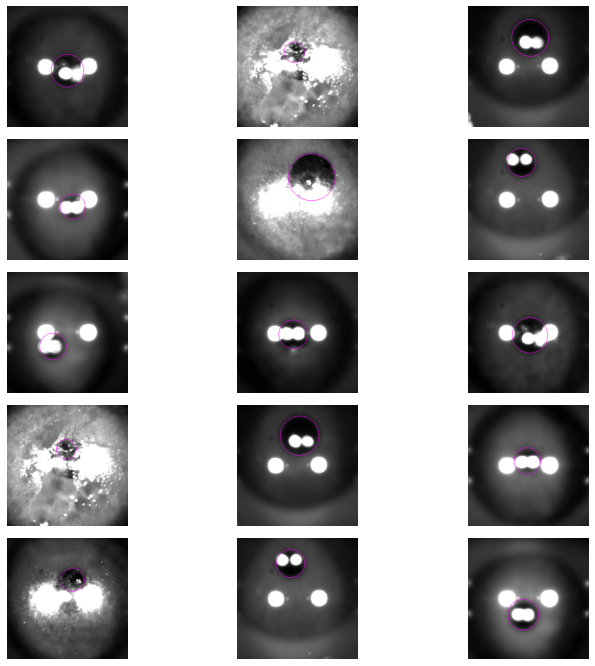

In [72]:
fullDS = csv_set.interleave(singleCSV)
#for (name,frameNo,OK,qua,x,y,R) in fullDS.take(10):   
#     print(f"{name.numpy()} - {frameNo.numpy()}; q: {qua.numpy()}")

fullDS = fullDS.map(loadByFrameNo)
displayDS(fullDS, 15, lambda img,pup,frameName : drawCircleImg(img, pup, frameName))

In [46]:
TEST_SZ = 1000
VALID_SZ = 1000
TRAIN_LENGTH = 11111 #info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 10000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# TODO try tf.keras.utils.image_dataset_from_directory
#for path in csv_set.take(10):
#     ds = singleCSV(path)
#     lst = list(iter(ds))
#     last = lst[-1]
#     print(f"processing {last}")
#     frame, para = loadByFrameNo(*last)
#     print("f{para}")

# shuffle csv data before loading images..
# better shuffle the filenames directly before loading image data
# shuffle().repeat(): "1 3 2, 1 3 2, 1 3 2" or "3 1 2, 3 1 2, 3 1 2"
fullDS = csv_set.interleave(singleCSV).shuffle(BUFFER_SIZE).map(loadByFrameNo)
for img,pup in fullDS.take(1):   
     print(pup)
     #print(np.mean(img, keepdims=True),img.shape)
#displayDS(fullDS, 5, lambda img,pup : drawCircleImg(img, pup))

# compute radiuses, X and Y
sum,num = fullDS.reduce((tf.zeros(3, tf.float32), 0.0), lambda s,item : (s[0] + item[1], s[1] + 1))
print("result: ",sum,num,sum/num)

train_batches = (fullDS
     .cache()
     .batch(BATCH_SIZE)
     .repeat()
     #.map(Augment())
     .prefetch(buffer_size=tf.data.AUTOTUNE))

#tfds.benchmark(train_batches, batch_size=BATCH_SIZE)
  
testS = fullDS.take(TEST_SZ) 
validS = fullDS.skip(TEST_SZ).take(VALID_SZ)   
trainS = fullDS.skip(TEST_SZ + VALID_SZ)  

def vgg_block(X, num_filters, num_convs, kernel_size=3, if_batch_norm=False):
     for _ in range(num_convs):
          X = tfl.Conv2D(num_filters, kernel_size, padding='same')(X)
          if if_batch_norm:
              X = tfl.BatchNormalization()(X)
          X = tfl.Activation('relu')(X)
     X = tfl.MaxPool2D((2,2), strides=(2,2))(X)
     return X

mm = CAE_generic(bottlenck_size=8, if_batch_norm=True)
#model = mm.complete(input_size=imageShape)
inputs = tfl.Input(shape=imageShape)
#X = mm.encoder_fun(inputs)
if_batch_norm=True
X = vgg_block(inputs, 32, num_convs=3, kernel_size=5, if_batch_norm=if_batch_norm)
X = vgg_block(X, 64, num_convs=2, kernel_size=5, if_batch_norm=if_batch_norm)
flatX = tfl.Flatten()(X)
X = tfl.Dense(8,activation="relu",name="extra_dense1")(flatX)
X = tfl.Dense(8,activation="relu",name="extra_dense2")(X)
X = tfl.Dense(3,activation="relu",name="final")(X)

model = keras.Model(inputs=inputs, outputs=X)
model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError(), metrics=['accuracy'])
model.summary()

model.fit(train_batches, epochs=5, steps_per_epoch=300)
#model_history = model.fit(train_batches, epochs=EPOCHS,
                         #  steps_per_epoch=STEPS_PER_EPOCH,
                         #  validation_steps=VALIDATION_STEPS,
                         #  validation_data=test_batches,
                         #  callbacks=[DisplayCallback()])

tf.Tensor([125.884995 127.524994  23.15    ], shape=(3,), dtype=float32)
result:  tf.Tensor([24832.086 24291.809 10424.617], shape=(3,), dtype=float32) tf.Tensor(202.0, shape=(), dtype=float32) tf.Tensor([122.93112  120.25648   51.607018], shape=(3,), dtype=float32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                          

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=10,
                            steps_per_epoch=STEPS_PER_EPOCH)
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

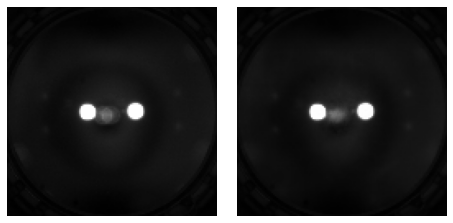

In [46]:
aa = next(iter(DS))
zz = model.predict(tf.expand_dims(aa, axis=0))
zz = zz.reshape(zz.shape[1:])
#yy = np.asarray(zz)
#print(yy.ndim)
#plt.imshow([aa,zz], cmap='gray')
display_dataset([aa,zz], 2)


# file listing on network does not work with Admin privileges
file_set = tf.data.Dataset.list_files(data_dir + "*.png")